In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4666 sha256=5a6655141e48db53fcf9cf4953ef4db1456918b3836a5d11025169c16eb6ab3e
  Stored in directory: /root/.cache/pip/wheels/c1/df/15/a88cdf68ce687574649f65063a743123e1bee79932b6eea3b6
Successfully built keras-layer-normalization


In [3]:
class Config:
  DATASET_PATH ="/content/drive/MyDrive/Research/secondary/Anomaly-Detection_Divya/Avenue_Dataset/Train"
  TEST_PATH = "/content/drive/MyDrive/Research/secondary/Anomaly-Detection_Divya/Avenue_Dataset/testing_videos"
  SAMPLE_TRAIN_PATH = "/content/drive/MyDrive/Research/secondary/Anomaly-Detection_Divya/Avenue_Dataset/sample_train"
  BATCH_SIZE = 4
  EPOCHS = 10
  MODEL_PATH = "/content/drive/MyDrive/Research/secondary/Anomaly-Detection_Divya/Avenue_Dataset/Train/model50.hdf5"

In [4]:
import os
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    
    clips = []
    errors = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.SAMPLE_TRAIN_PATH)):
        if isdir(join(Config.SAMPLE_TRAIN_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.SAMPLE_TRAIN_PATH, f))):
                #print(c)
                if str(join(join(Config.SAMPLE_TRAIN_PATH, f), c))[-4:] == ".tif":
                #if str(join(join(Config.SAMPLE_TRAIN_PATH, f), c))[-3:] == "tif":
                    #print("true")
                    try:
                      img = Image.open(join(join(Config.SAMPLE_TRAIN_PATH, f), c)).resize((256, 256))
                      img = np.array(img, dtype=np.float32) / 256.0
                      all_frames.append(img)
                    except OSError:
                      errors.append(join(join(Config.SAMPLE_TRAIN_PATH, f), c))
                      continue
           # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 4):
            #for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
                print(f"{len(clips)} done.")
    print("[ERROR FILES]")
    for k in errors:
      print(k)
    return clips   

In [5]:
import keras
import numpy as np
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
from keras.layers import Dense
def get_model(reload_model=True):
    print(reload_model) 
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    
    print("Loading Training Set...")
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    print(training_set.shape)
    print("Training set loaded")
    
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    
    seq.summary()
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), run_eagerly=True)    
    seq.fit(training_set, training_set, batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=True)
    seq.save(Config.MODEL_PATH)
    
    return seq

In [6]:
model = get_model()

True
Loading Training Set...
1 done.
2 done.
3 done.
4 done.
5 done.
6 done.
7 done.
8 done.
9 done.
10 done.
11 done.
12 done.
[ERROR FILES]
(12, 10, 256, 256, 1)
Training set loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 64, 64, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 32, 32, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 32, 32, 64)   128       
 rNo

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
3/3 [==============================] - 35s 2s/step - loss: 0.1179
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 0.0869
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.0754
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.0696
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.0631
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.0559
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.0487
Epoch 8/10
3/3 [==============================] - 7s 2s/step - loss: 0.0545
Epoch 9/10
3/3 [==============================] - 7s 2s/step - loss: 0.0380
Epoch 10/10
3/3 [==============================] - 7s 2s/step - loss: 0.0344


In [7]:
def get_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.TEST_PATH)):
        if str(join(Config.TEST_PATH, f))[-4:] == ".tif":
            img = Image.open(join(Config.TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


In [8]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model(False)
    #print("got model")
    test = get_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    print(sequences_reconstruction_cost)
    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


False
(200, 256, 256, 1)
got data
48/48 [==============================] - 30s 626ms/step
[102.86842433 102.8684245  102.8684245  102.8684242  102.86842413
 102.86842425 102.86842428 102.86842447 102.8684243  102.86842398
 102.86842424 102.86842408 102.86842429 102.86842437 102.86842397
 102.86842398 102.8684238  102.86842432 102.86842414 102.86842429
 102.86842406 102.86842421 102.86842388 102.86842413 102.86842421
 102.86842392 102.86842404 102.86842422 102.86842453 102.86842424
 102.86842406 102.86842401 102.86842449 102.86842399 102.86842438
 102.86842449 102.86842424 102.86842475 102.86842425 102.86842428
 102.86842446 102.86842411 102.86842409 102.86842429 102.86842433
 102.86842425 102.86842425 102.86842431 102.86842438 102.86842424
 102.86842393 102.86842364 102.86842414 102.86842397 102.8684243
 102.86842415 102.86842448 102.86842423 102.86842385 102.86842432
 102.86842422 102.86842378 102.86842428 102.86842405 102.86842433
 102.86842415 102.86842429 102.86842414 102.86842422 

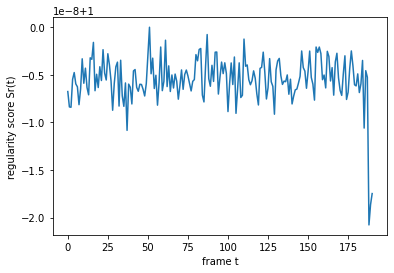

In [9]:
evaluate()